In [1]:
import sys
print(sys.version)
print(*sys.path, sep='\n')

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload

/home/lukec/venv/lib/python3.6/site-packages
/home/lukec/Downloads/jax/build
/home/lukec/.local/lib/python3.6/site-packages
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/home/lukec/venv/lib/python3.6/site-packages/IPython/extensions
/home/lukec/.ipython


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [4]:
# parameters for trained CNN
root = os.path.join('.', 'dataset_root')
# mean, std = [0.13066046], [0.30150425] # based on training set
batch_size = 128
lr = 0.01
momentum=0.9
step_size=6
gamma=0.1
epochs = 40

In [5]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [6]:
# prepare data
# foolbox model expects raw numpy array as image
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)
])
train_dataset = tv.datasets.MNIST(
    root,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    root,
    train=False, 
    download=True,
    transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 5**2 * 64)
        self.convt1 = nn.ConvTranspose2d(64, 64, 3, 2)
        self.convt2 = nn.ConvTranspose2d(64, 32, 3, 2)
        self.convt3 = nn.ConvTranspose2d(32, 32, 3, 1)
        self.convt4 = nn.ConvTranspose2d(32, 1, 3, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        print(x.size())
        x = torch.reshape(x, (x.size(0), 64, 5, 5))
        x = F.relu(self.convt1(x))
        print(x.size())
        x = F.relu(self.convt2(x))
        print(x.size())
        x = F.relu(self.convt3(x))
        print(x.size())
        x = self.convt4(x)
        x = F.interpolate(x, (28, 28))
        return x

In [13]:
x = torch.randn(1,128)
decoder = Decoder()
output = decoder(x)
output.size()

torch.Size([1, 1600])
torch.Size([1, 64, 11, 11])
torch.Size([1, 32, 23, 23])
torch.Size([1, 32, 25, 25])


torch.Size([1, 1, 28, 28])

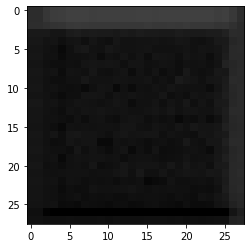

In [15]:
plt.figure()
imshow(output.cpu().detach())
plt.show()
assert False

In [ ]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0
        
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        output = model(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()

        # for display
        total_loss += loss.item() * batch_size
        preds = output.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(train_loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [ ]:
def validate(model, loader):
    model.eval()
    total_loss = 0.
    corrects = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            loss = F.nll_loss(output, y)
            total_loss += loss.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(test_loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [ ]:
# NOTE: NO GPU AT SCHOOL!
model1 = Net1()
model_linear = Model_linear()
model_softmax = torch.nn.Sequential(
    model1,
    model_linear,
    torch.nn.LogSoftmax(dim=1)
)
model_softmax.to(device)
optimizer = torch.optim.SGD(model_softmax.parameters(), lr=lr, momentum=momentum)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=step_size, 
    gamma=gamma)

print(model_softmax)

In [ ]:
since = time.time()
for epoch in range(epochs):
    start = time.time()
    
    best_model_state = copy.deepcopy(model_softmax.state_dict())
    best_tr_acc = 0.0
    best_va_acc = 0.0
    prev_loss = 1e10
    
    tr_loss, tr_acc = train(model_softmax, train_loader, optimizer)
    va_loss, va_acc = validate(model_softmax, test_loader)
    lr_scheduler.step()
    
    # save best result
    if tr_acc >= best_tr_acc and va_acc >= best_va_acc:
        best_model_state = copy.deepcopy(model_softmax.state_dict())
        best_tr_acc = tr_acc
        best_va_acc = va_acc
    
    # display
    time_elapsed = time.time() - start
    print(('[{:2d}] {:.0f}m {:.1f}s Train Loss: {:.4f} Accuracy: {:.4f}%, ' +
        'Test Loss: {:.4f} Accuracy: {:.4f}%').format(
            epoch+1, time_elapsed // 60, time_elapsed % 60,
            tr_loss, tr_acc*100.,
            va_loss, va_acc*100.))
    
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))
print(f'Best val Acc: {best_va_acc:4f}')

In [ ]:
torch.save(model_softmax.state_dict(), 'mnist_model3.pt')

In [ ]:
pool = nn.MaxPool2d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2)
input_ = torch.ones((1,1,4,4))
output, indices = pool(input_)
print(indices)

In [ ]:
output

In [ ]:
unpool(output, indices)